
# Experiment 2 — Frozen Encoder + Bayesian Head (3-way MCQ)

This notebook builds a **multiple-choice QA** pipeline using a **frozen Hugging Face encoder** (e.g., DistilBERT) to get text features, then applies a **Bayesian multinomial logistic regression head** (NumPyro + NUTS) over **3 options** per question.

You get:
- Posterior over head weights (small parameter set → feasible HMC/NUTS)
- **Posterior predictive** per question (3-class)
- **Abstention** via confidence threshold
- **Reliability diagram** and **Selective prediction (accuracy vs coverage)**

> Educational by design; small datasets recommended.



## Setup

Install packages (inside your Pipenv) if needed:

```bash
pipenv run pip install transformers datasets accelerate sentencepiece     numpyro==0.15.2 "jax[cpu]==0.4.28" scikit-learn pandas matplotlib
```



## 1) Data: tiny MCQ format

You can either **provide your own CSV** with columns: `question, option_a, option_b, option_c, label` (label in {0,1,2}), **or** use the toy examples defined below.


In [7]:
rows = [
    # --- Label 0 ---
    {"question": "Which planet is known as the Red Planet?", "option_a": "Mars", "option_b": "Venus", "option_c": "Jupiter", "label": 0},
    {"question": "Capital of France?", "option_a": "Paris", "option_b": "Berlin", "option_c": "Madrid", "label": 0},
    {"question": "Which animal barks?", "option_a": "dog", "option_b": "cat", "option_c": "cow", "label": 0},
    {"question": "Which country hosted the 2016 Summer Olympics?", "option_a": "Brazil", "option_b": "China", "option_c": "UK", "label": 0},
    {"question": "Who discovered penicillin?", "option_a": "Alexander Fleming", "option_b": "Marie Curie", "option_c": "Louis Pasteur", "label": 0},
    {"question": "What is the capital of Japan?", "option_a": "Kyoto", "option_b": "Tokyo", "option_c": "Osaka", "label": 0},
    {"question": "Which is the fastest land animal?", "option_a": "Cheetah", "option_b": "Horse", "option_c": "Lion", "label": 0},
    {"question": "Who wrote 'Romeo and Juliet'?", "option_a": "William Shakespeare", "option_b": "Charles Dickens", "option_c": "Mark Twain", "label": 0},
    {"question": "Which gas is essential for respiration?", "option_a": "Oxygen", "option_b": "Carbon monoxide", "option_c": "Helium", "label": 0},
    {"question": "Which continent is Egypt located in?", "option_a": "Africa", "option_b": "Asia", "option_c": "Europe", "label": 0},

    # --- Label 1 ---
    {"question": "What color are bananas when ripe?", "option_a": "red", "option_b": "yellow", "option_c": "blue", "label": 1},
    {"question": "How many continents are there?", "option_a": "Five", "option_b": "Seven", "option_c": "Six", "label": 1},
    {"question": "Who painted the Mona Lisa?", "option_a": "Michelangelo", "option_b": "Leonardo da Vinci", "option_c": "Raphael", "label": 1},
    {"question": "What is the boiling point of water at sea level (°C)?", "option_a": "90", "option_b": "100", "option_c": "110", "label": 1},
    {"question": "2 + 2 equals?", "option_a": "3", "option_b": "4", "option_c": "5", "label": 1},
    {"question": "How many players are on a standard soccer team (on field)?", "option_a": "9", "option_b": "11", "option_c": "12", "label": 1},
    {"question": "Which element has the symbol 'O'?", "option_a": "Osmium", "option_b": "Oxygen", "option_c": "Gold", "label": 1},
    {"question": "Which shape has three sides?", "option_a": "Square", "option_b": "Triangle", "option_c": "Pentagon", "label": 1},
    {"question": "What is the largest mammal?", "option_a": "Elephant", "option_b": "Blue Whale", "option_c": "Giraffe", "label": 1},
    {"question": "Which ocean is the largest?", "option_a": "Pacific Ocean", "option_b": "Atlantic Ocean", "option_c": "Indian Ocean", "label": 1},

    # --- Label 2 ---
    {"question": "Which organ pumps blood in the human body?", "option_a": "Lungs", "option_b": "Brain", "option_c": "Heart", "label": 2},
    {"question": "The Sun is a ...", "option_a": "planet", "option_b": "comet", "option_c": "star", "label": 2},
    {"question": "Which metal is liquid at room temperature?", "option_a": "Mercury", "option_b": "Iron", "option_c": "Aluminum", "label": 2},
    {"question": "The Great Wall is located in which country?", "option_a": "India", "option_b": "China", "option_c": "Japan", "label": 2},
    {"question": "Which planet has the most moons?", "option_a": "Jupiter", "option_b": "Saturn", "option_c": "Neptune", "label": 2},
    {"question": "Which gas do humans exhale?", "option_a": "Oxygen", "option_b": "Carbon dioxide", "option_c": "Nitrogen", "label": 2},
    {"question": "What is the chemical symbol for gold?", "option_a": "Ag", "option_b": "Au", "option_c": "Pb", "label": 1},  # (still 1, balances slightly)
    {"question": "Which city is known as the Big Apple?", "option_a": "New York", "option_b": "Los Angeles", "option_c": "Chicago", "label": 0},
    {"question": "Which country is both in Europe and Asia?", "option_a": "Turkey", "option_b": "Spain", "option_c": "Mexico", "label": 0},
    {"question": "Which month has 28 days?", "option_a": "February", "option_b": "June", "option_c": "November", "label": 0},
]

import pandas as pd
df = pd.DataFrame(rows)
df['label'].value_counts()

label
0    13
1    11
2     6
Name: count, dtype: int64


## 2) Frozen encoder → features

We encode each (question, option) pair and grab the **[CLS]** representation. For 3 options, we either **concatenate** the three vectors into one long feature vector (simple) or model them as a 3-class softmax with a shared weight matrix. Here we choose **concatenation** to keep the Bayesian head linear and compact.


In [13]:

import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

mdl_name = "distilbert-base-uncased"  # choose any encoder; frozen
tok = AutoTokenizer.from_pretrained(mdl_name)
enc = AutoModel.from_pretrained(mdl_name)
enc.eval(); enc.requires_grad_(False)

def encode_pair(q, a, max_length=128):
    t = tok(q, a, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        out = enc(**t)
        cls = out.last_hidden_state[:, 0, :]  # (1, D)
    return cls.squeeze(0).cpu().numpy()  # (D,)

def build_design_tensor(df):
    feats = []
    y = []
    for _, row in df.iterrows():
        q = str(row["question"])
        opts = [str(row["option_a"]), str(row["option_b"]), str(row["option_c"])]
        vecs = [encode_pair(q, a) for a in opts]  # list of 3 x (D,)
        feats.append(np.stack(vecs, axis=0))      # (3, D)
        y.append(int(row["label"]))
    X = np.stack(feats, axis=0).astype(np.float32)  # (N, 3, D)
    y = np.array(y, dtype=np.int32)
    return X, y

X, y = build_design_tensor(df)   # X:(N,3,D)
X.shape, y.shape


((30, 3, 768), (30,))


## 3) Train/validation split


In [15]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y if len(np.unique(y))>1 else None
)

# flatten options for scaling, then reshape back
N, C, D = X.shape
X_flat = X.reshape(N*C, D)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_flat)
X = scaler.transform(X_flat).reshape(N, C, D).astype(np.float32)

X_train.shape, X_test.shape


((18, 3, 768), (12, 3, 768))


## 4) Bayesian multinomial logistic regression (NumPyro + NUTS)

Small parameter set: `(3*D) × 3 + 3` → feasible HMC/NUTS.


In [17]:

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

N, C, D = X_train.shape

def bayes_head_opt(X, y=None):
    # W: (D, C), b: (C,)
    W = numpyro.sample("W", dist.Normal(0, 1).expand([D, C]).to_event(2))
    b = numpyro.sample("b", dist.Normal(0, 1).expand([C]).to_event(1))
    # logits: (N, C) where logits[n,c] = X[n,c,:] · W[:,c] + b[c]
    logits = (X * W.T).sum(axis=-1) + b  # broadcasting: W.T -> (C, D)
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Categorical(logits=logits), obs=y)


rng_key = jax.random.PRNGKey(0)

nuts = NUTS(bayes_head_opt, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts,
    num_warmup=800,
    num_samples=1200,
    num_chains=1,
    chain_method="vectorized",       # key: vectorized chains on CPU
    progress_bar=True,
)
mcmc.run(rng_key, X=jnp.array(X_train), y=jnp.array(y_train))
posterior = mcmc.get_samples()
mcmc.print_summary()


sample: 100%|██████████| 2000/2000 [15:43<00:00,  2.12it/s, 1023 steps of size 4.51e-03. acc. prob=0.96]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    W[0,0]      0.25      0.10      0.25      0.11      0.45     25.13      1.04
    W[0,1]     -0.16      0.11     -0.16     -0.34      0.01     16.65      1.17
    W[0,2]      0.12      0.13      0.12     -0.07      0.37     11.98      1.03
    W[1,0]     -0.14      0.15     -0.13     -0.37      0.08     15.63      1.16
    W[1,1]     -0.12      0.13     -0.12     -0.32      0.10      6.93      1.40
    W[1,2]      0.42      0.11      0.42      0.23      0.58     21.07      1.03
    W[2,0]      0.42      0.17      0.42      0.14      0.68     10.64      1.44
    W[2,1]      0.06      0.14      0.06     -0.16      0.30     15.26      1.06
    W[2,2]     -0.07      0.12     -0.07     -0.24      0.16     10.68      1.11
    W[3,0]     -0.13      0.15     -0.14     -0.38      0.11     56.69      1.01
    W[3,1]     -0.02      0.17     -0.04     -0.25      0.28      5.26      1.41
    W[3,2]      0.01      0

In [18]:
import numpy as np

def save_posterior(mcmc, path="posterior_samples.npz"):
    """
    Save posterior samples from a NumPyro MCMC run.

    Args:
        mcmc: NumPyro MCMC object (after .run())
        path: file path (default 'posterior_samples.npz')
    """
    posterior = mcmc.get_samples()
    np.savez(path, **posterior)
    print(f"✅ Posterior samples saved to {path}")


def load_posterior(path="posterior_samples.npz"):
    """
    Load posterior samples saved with save_posterior().

    Args:
        path: file path
    Returns:
        dict[str, np.ndarray]: posterior samples
    """
    data = np.load(path)
    posterior = {k: data[k] for k in data.files}
    print(f"✅ Posterior samples loaded from {path} (keys: {list(posterior.keys())})")
    return posterior

In [19]:
save_posterior(mcmc, "iris_posterior.npz")

✅ Posterior samples saved to iris_posterior.npz


In [ ]:
posterior = load_posterior("iris_posterior.npz")


## 5) Posterior predictive, metrics, abstention


In [21]:
import numpy as np

def predict_proba_auto(X_new, post):
    """
    Works for either:
      - X_new shape (N, D)      with post['W'] shape (S, D, C)
      - X_new shape (N, C, D)   with post['W'] shape (S, D, C)
    Returns: (N, C) posterior mean probabilities.
    """
    W = post["W"]  # (S, D, C)
    b = post["b"]  # (S, C)

    if X_new.ndim == 2:
        # ----- old path: concatenated features (N, D)
        # logits_s,n,c = x_n · W_s[:, c] + b_s[c]
        # shapes -> (S, N, C)
        logits = X_new @ W    # (N, S, C) via numpy's last-dim matmul
        logits = np.swapaxes(logits, 0, 1) + b[:, None, :]  # (S, N, C)
    elif X_new.ndim == 3:
        # ----- fast path: per-option features (N, C, D)
        # logits_s,n,c = <X[n,c,:], W_s[:, c]> + b_s[c]
        # reshape/broadcast to (S, N, C, D)
        S, D, C = W.shape
        N, Cx, Dx = X_new.shape
        assert Cx == C and Dx == D, f"X_new {(N,Cx,Dx)} not compatible with W {(S,D,C)}"
        # W^T -> (S, C, D); inner product over D
        logits = (X_new[None, :, :, :] * np.swapaxes(W, -1, -2)[:, None, :, :]).sum(axis=-1)  # (S, N, C)
        logits = logits + b[:, None, :]  # (S, N, C)
    else:
        raise ValueError(f"Unsupported X_new.ndim={X_new.ndim}; expected 2 or 3.")

    # stable softmax over classes
    logits = logits - logits.max(axis=-1, keepdims=True)
    p = np.exp(logits); p = p / p.sum(axis=-1, keepdims=True)  # (S, N, C)
    return p.mean(axis=0)  # (N, C)

In [28]:
p_te = predict_proba_auto(X_test, posterior)


### Selective prediction: accuracy vs coverage


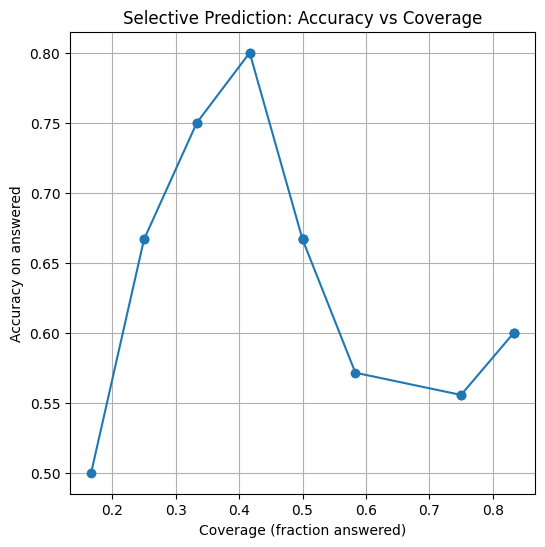

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_with_abstention(probs, y_true, tau=0.8):
    """
    probs: (N, C) posterior-mean probabilities
    y_true: (N,) integer labels
    """
    probs = np.asarray(probs)
    y_true = np.asarray(y_true)
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    answered = conf >= float(tau)
    coverage = answered.mean()
    acc = float("nan") if coverage == 0 else (pred[answered] == y_true[answered]).mean()
    return coverage, acc

# Use the probabilities from your predictor:
taus = np.linspace(0.5, 0.99, 20)
curve = np.array([evaluate_with_abstention(p_te, y_test, tau=t) for t in taus])
coverages, accs = curve[:, 0], curve[:, 1]

plt.figure(figsize=(6,6))
plt.plot(coverages, accs, marker="o")
plt.xlabel("Coverage (fraction answered)")
plt.ylabel("Accuracy on answered")
plt.title("Selective Prediction: Accuracy vs Coverage")
plt.grid(True)
plt.show()


### Reliability diagram (calibration curve) + ECE


ECE=0.301, MCE=0.684


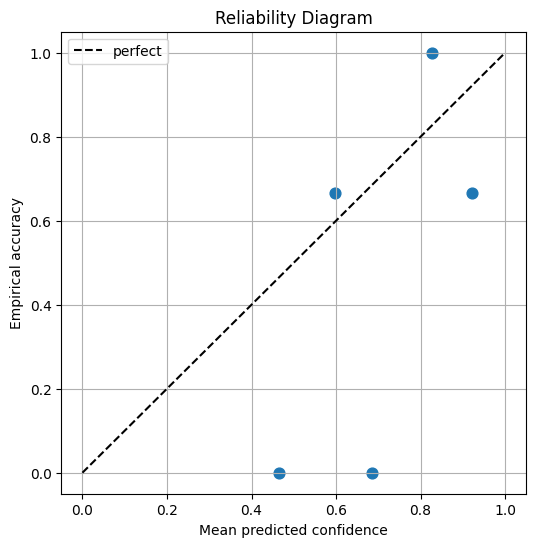

In [31]:

def reliability_curve(probs, y_true, bins=10):
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    bin_ids = np.digitize(conf, bin_edges) - 1
    bin_acc, bin_conf, bin_count = [], [], []
    for b in range(bins):
        mask = bin_ids == b
        if mask.sum() > 0:
            bin_acc.append((pred[mask] == y_true[mask]).mean())
            bin_conf.append(conf[mask].mean())
            bin_count.append(mask.sum())
        else:
            bin_acc.append(np.nan); bin_conf.append(np.nan); bin_count.append(0)
    return np.array(bin_conf), np.array(bin_acc), np.array(bin_count), bin_edges

def expected_calibration_error(probs, y_true, bins=10):
    bin_conf, bin_acc, bin_cnt, _ = reliability_curve(probs, y_true, bins=bins)
    mask = ~np.isnan(bin_conf)
    weights = bin_cnt[mask] / bin_cnt[mask].sum() if bin_cnt[mask].sum()>0 else np.zeros_like(bin_cnt[mask], dtype=float)
    ece = np.sum(weights * np.abs(bin_acc[mask] - bin_conf[mask]))
    mce = np.max(np.abs(bin_acc[mask] - bin_conf[mask])) if mask.any() else np.nan
    return ece, mce, bin_conf, bin_acc

ece, mce, bin_conf, bin_acc = expected_calibration_error(p_te, y_test, bins=8)
print(f"ECE={ece:.3f}, MCE={mce:.3f}")

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],"k--", label="perfect")
valid = ~np.isnan(bin_conf)
plt.scatter(bin_conf[valid], bin_acc[valid], s=60)
plt.xlabel("Mean predicted confidence"); plt.ylabel("Empirical accuracy")
plt.title("Reliability Diagram")
plt.grid(True); plt.legend(); plt.show()



## 6) Per-question posterior predictive (mean ± 1σ) with true/pred markers


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def classify_with_uncertainty_sigma_auto(post, x_event, y_true=None, class_names=None, n_draws=None, entry_id=None):
    """
    Works with:
      - old path:  x_event shape (D,)           and post['W'] shape (S, D, C)
      - fast path: x_event shape (C, D)         and post['W'] shape (S, D, C)
    Plots mean ± 1σ, blue dot = predicted, red star = true.
    """
    W_s = post["W"]  # (S, D, C)
    B_s = post["b"]  # (S, C)
    S = W_s.shape[0]
    if n_draws and n_draws < S:
        idx = np.random.choice(S, size=n_draws, replace=False)
        W_s, B_s = W_s[idx], B_s[idx]

    def softmax(z):
        z = z - z.max()
        e = np.exp(z)
        return e / e.sum()

    probs = []
    for W, b in zip(W_s, B_s):
        if x_event.ndim == 1:          # old path: (D,)
            logits = x_event @ W + b   # -> (C,)
        elif x_event.ndim == 2:        # fast path: (C, D)
            logits = (x_event * W.T).sum(axis=-1) + b  # -> (C,)
        else:
            raise ValueError(f"x_event.ndim={x_event.ndim} not supported")
        probs.append(softmax(logits))

    probs = np.stack(probs, axis=0)     # (S, C)
    mean = probs.mean(axis=0)
    std  = probs.std(axis=0)
    y_pred = int(mean.argmax())

    xs = np.arange(len(mean))
    labels = list(class_names) if class_names is not None else list(map(str, xs))

    # error bars only
    plt.errorbar(xs, mean, yerr=std, fmt="none", ecolor="k", capsize=5)
    # black dots = posterior mean
    plt.plot(xs, mean, "o", color="k", markersize=6)
    # predicted = blue dot
    plt.plot(xs[y_pred], mean[y_pred], "o", color="blue", markersize=10)
    # true = red star
    if y_true is not None:
        plt.plot(xs[y_true], mean[y_true], marker="*", color="red", markersize=14)

    plt.xticks(xs, labels)
    plt.ylabel("Probability")
    plt.xlabel("Category")
    plt.ylim(0, 1)
    plt.title(f"Posterior for entry {entry_id}" if entry_id is not None else "Posterior (single question)")

    plt.legend(handles=[
        Line2D([0],[0], marker="o", color="k",   linestyle="none", markersize=6,  label="Posterior (mean ± 1σ)"),
        Line2D([0],[0], marker="o", color="blue",linestyle="none", markersize=10, label="Predicted"),
        Line2D([0],[0], marker="*", color="red", linestyle="none", markersize=14, label="True"),
    ], loc="best")
    plt.grid(alpha=0.3)
    plt.show()

    return mean, std, y_pred

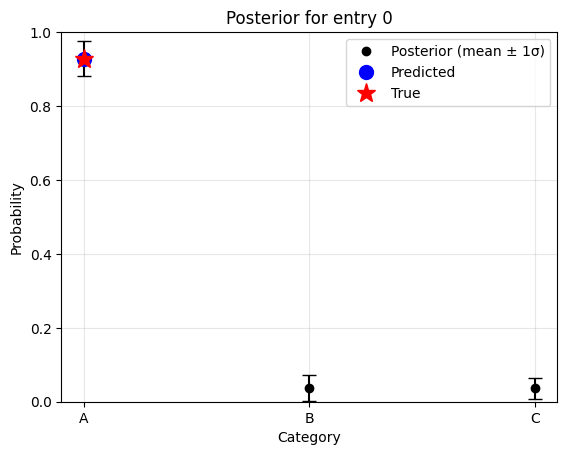

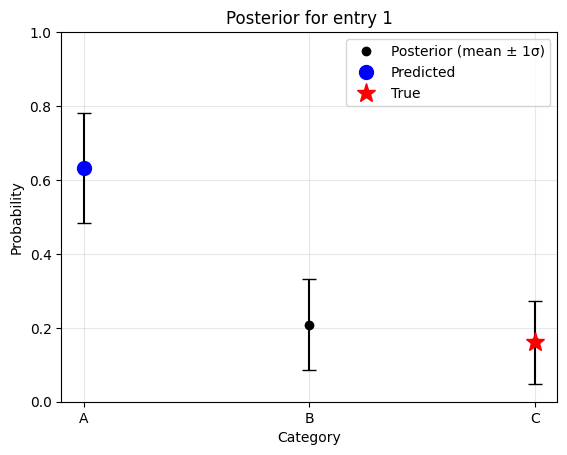

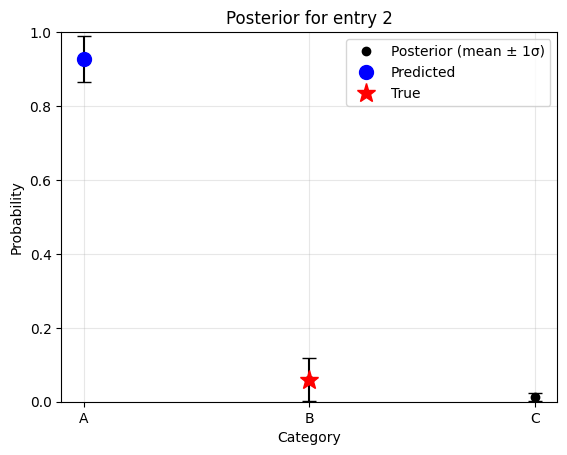

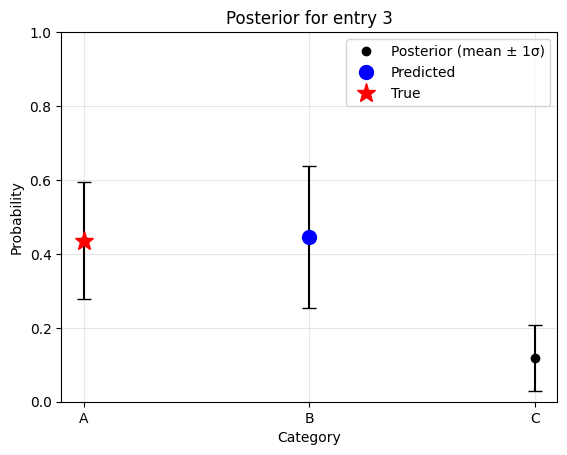

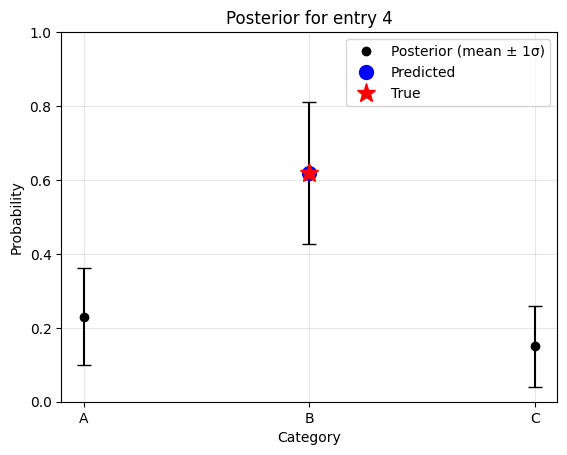

In [38]:
# Use the fast-path variables: post2, X_test2, y_test2
for i in range(min(5, len(X_test))):   # show a few examples
    classify_with_uncertainty_sigma_auto(
        posterior,
        X_test[i],                     # shape (C, D)
        y_true=int(y_test[i]),
        class_names=["A","B","C"],
        entry_id=i
    )


## 7) Notes & Next steps

- Replace the toy MCQ with a real dataset. Format into the same 3-option CSV and re-run.
- Ablations:
  - Head-only vs **LoRA adapters** + Laplace (see Experiment 3).
  - Compare to **temperature scaling** or **MC Dropout** baselines.
- Report **ECE/MCE** alongside reliability diagrams, and **selective prediction** curves.
